# Modeling
This python notebook performs regressions on data pulled from a processed mongo DB created by GASpy. It then saves these regressions into pickles (for later use) and creates parity plots of the regression fits.

Execution times vary depending on the size of the dataset and type of regression that you do. The regression illustrated here takes about 5 minutes to run. The predictions illustrated here will take about 16-24 hours to run (apiece). We use a separate script that uses 32 threads to do the prediction, which takes only 30-45 minutes to run (apiece).

# Initialize

In [1]:
# Modify the path so that we use GASpy_dev instead of GASpy
gaspy_path = '/global/project/projectdirs/m2755/GASpy/'

In [2]:
# Modify the path so that we use GASpy_dev instead of GASpy
#import sys
#gaspy_path = '/global/project/projectdirs/m2755/GASpy_dev/'
#sys.path.insert(0, gaspy_path)
#sys.path.insert(0, gaspy_path + '/GASpy_feedback')
#sys.path.insert(0, gaspy_path + '/GASpy_regressions')

In [2]:
# Importing
import pdb
from gaspy_regress.regressor import GASpyRegressor
from gaspy_regress import gio, plot, predict
from gaspy.utils import vasp_settings_to_str, read_rc, docs_to_pdocs, print_dict
from gaspy import defaults

VASP_SETTINGS = vasp_settings_to_str({'gga': 'RP',
                                      'pp_version': '5.4',
                                      'encut': 350})

# Regress

In [3]:
import copy
from tpot import TPOTRegressor

In [4]:
model_name = 'TPOT'
features = ['coordatoms_chemfp0', 'neighbors_chemfp0']
responses = ['energy']
blocks = ['adsorbate']

In [5]:
tpot = TPOTRegressor(
                     generations=1,
                     population_size=16,
                     offspring_size=16,
                     verbosity=2,
                     random_state=42,
                     scoring='neg_median_absolute_error',
                     n_jobs=16,
                    )

model = GASpyRegressor(features=features, responses=responses,
                       blocks=blocks, vasp_settings=VASP_SETTINGS,
                       dim_red='pca', #n_components='mle', svd_solver='full',
                       #train_size=0.8, dev_size=0.1)
                       train_size=0.9)
                       #train_size=1)

fit_blocks = [('CO',), ('H',)]
#fit_blocks = [('CO',)]
#fit_blocks = None

model.fit_tpot(tpot, model_name=model_name, blocks=fit_blocks)

/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



Starting to pull documents...


49727it [00:01, 40180.97it/s]
/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-linux-x86_64.egg/pymatgen/ext/matproj.py:106: UserWarning:

If you query for structure data encoded using MP's Structure Notation Language (SNL) format and you use `mp_decode=True` (the default) for MPRester queries, you should install dependencies via `pip install pymatgen[matproj.snl]`.

  0%|          | 0/1353 [00:00<?, ?it/s]

Beginning to pull data from the Materials Project...


100%|██████████| 1353/1353 [03:40<00:00,  8.78it/s]
/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning:

Mean of empty slice.

/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning:

invalid value encountered in double_scalars

/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



Generation 1 - Current best internal CV score: 0.0879324760365

Best pipeline: ElasticNetCV(RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.25, min_samples_leaf=1, min_samples_split=2, n_estimators=100), l1_ratio=0.7, tol=0.01)


Generation 1 - Current best internal CV score: 0.0715812810577

Best pipeline: ElasticNetCV(RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.25, min_samples_leaf=1, min_samples_split=2, n_estimators=100), l1_ratio=0.7, tol=0.01)


In [ ]:
gio.dump_model(model)

In [6]:
model = gio.load_model(model_name, features, responses, blocks)

In [7]:
print_dict(model.calc_performance_metric('RMSE'))

('H',)
	test
		0.366270967814
	all
		0.229453917355
	train
		0.208058775816
('CO',)
	test
		0.318403649696
	all
		0.168595900076
	train
		0.143526093513


In [8]:
print_dict(model.calc_performance_metric('MAE'))

('H',)
	test
		0.164409280904
	all
		0.0893664336122
	train
		0.0807479837542
('CO',)
	test
		0.177574746429
	all
		0.0763258688687
	train
		0.0654665463283


In [9]:
print_dict(model.calc_performance_metric('MAD'))

('H',)
	test
		0.0711896157544
	all
		0.0176062590459
	train
		0.0139829579887
('CO',)
	test
		0.0832918114022
	all
		0.0221695836538
	train
		0.0168476188298


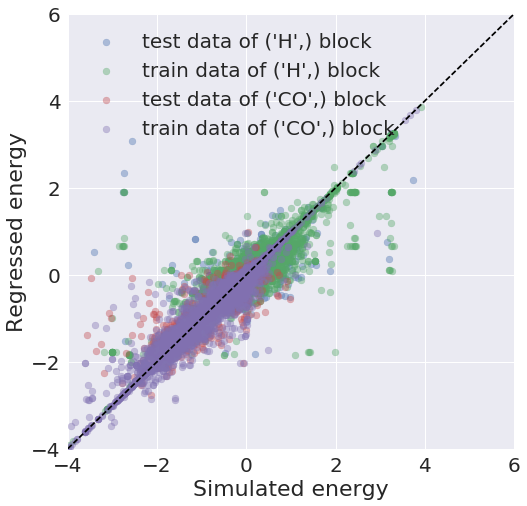

In [13]:
x, y, text = model.parity_plot(plotter='matplotlib', figsize=(8, 8), alpha=0.4)

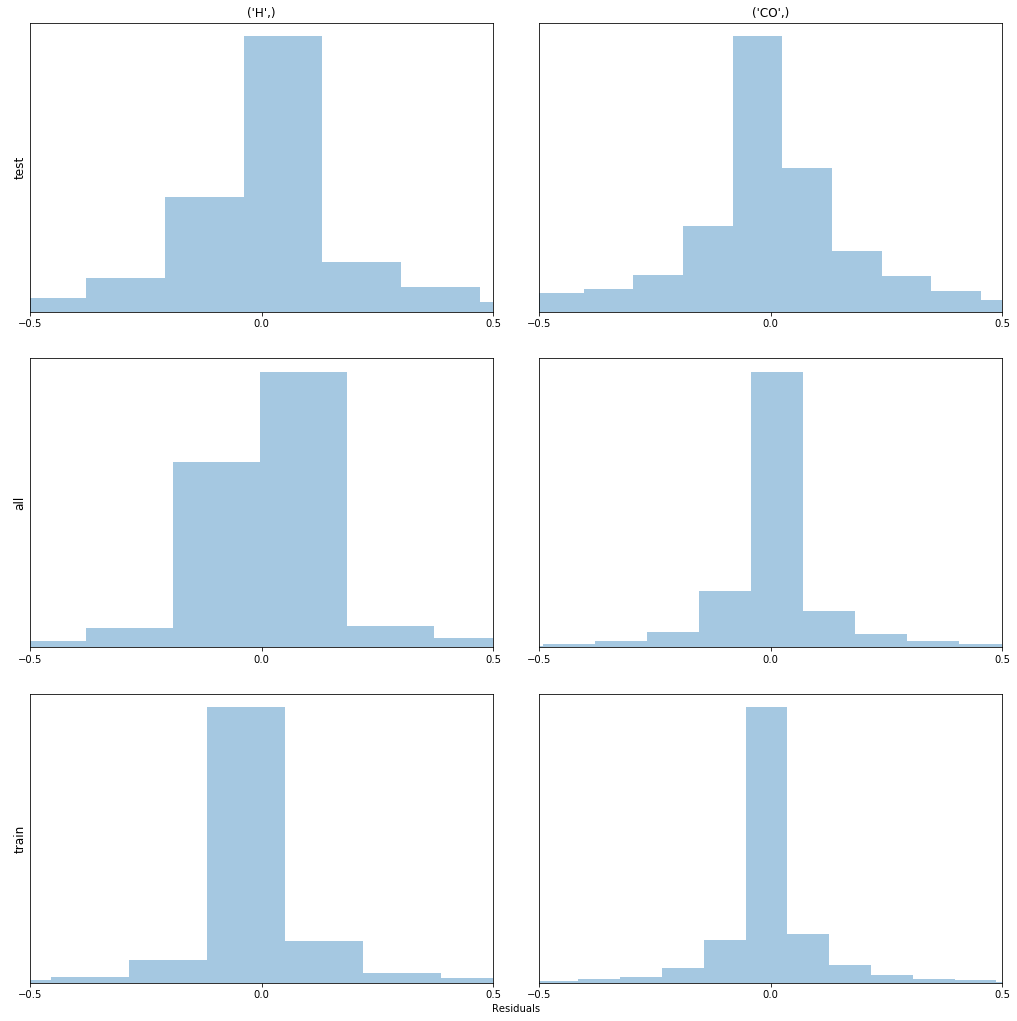

In [12]:
model.residual_plot(xlim=[-0.5, 0.5], xticks=[-0.5, 0, 0.5])

# Predict

## CO$_2$ Reduction

In [12]:
regressor_block = ('CO',)
adsorbate = 'CO'
system = 'CO2RR'
scale = 'log'

In [ ]:
co2_data = predict.volcano(H, regressor_block, system,excel_file_path,
                           scale, adsorbate, processes=4)

In [ ]:
gio.dump_predictions(co2_data, regressor=H, system=system)

In [13]:
co2_data = gio.load_predictions(model_name, features, responses, blocks, system)

In [ ]:
plot.volcano(co2_data, excel_file_path, system, scale)

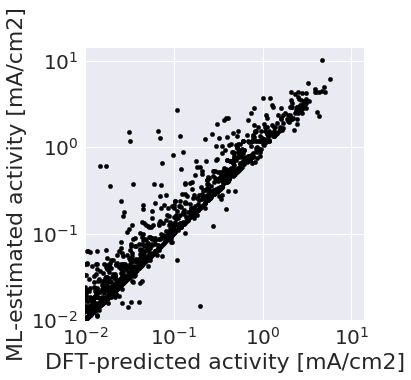

In [14]:
plot.filtered_parity(co2_data, scale=scale, plot_type='matplotlib', plot_range=[0.01, 14],
                     x_label='DFT-predicted activity [mA/cm2]',
                     y_label='ML-estimated activity [mA/cm2]',
                     title='Activity on surface minima')

In [ ]:
plot.filtered_parity(co2_data, scale=scale, plot_type='plotly', plot_range=[0.01, 14],
                     x_label='DFT-predicted activity [mA/cm2]',
                     y_label='ML-estimated activity [mA/cm2]',
                     title='Activity on surface minima')

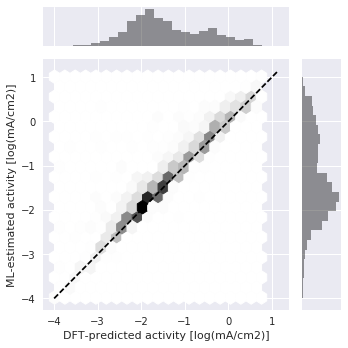

In [15]:
plot.filtered_parity(co2_data, scale=scale, plot_type='hex', plot_range=[0.0001, 14],
                     save=True,
                     x_label='DFT-predicted activity [log(mA/cm2)]',
                     y_label='ML-estimated activity [log(mA/cm2)]',
                     title='Activity parity on surface minima')

## HER

In [16]:
regressor_block = ('H',)
adsorbate = 'H'
system = 'HER'
scale = 'log'

In [ ]:
her_data = predict.volcano(H, regressor_block, system, excel_file_path, scale, adsorbate)

In [ ]:
gio.dump_predictions(her_data, regressor=H, system=system)

In [17]:
her_data = gio.load_predictions(model_name, features, responses, blocks, system)

In [ ]:
plot.volcano(her_data, excel_file_path, system, scale)

In [ ]:
plot.filtered_parity(her_data, scale=scale, plot_type='plotly', plot_range=[1e-12, 1e-3],
                     x_label='DFT-predicted activity [A/cm2]',
                     y_label='ML-estimated activity [A/cm2]',
                     title='Activity on surface minima')

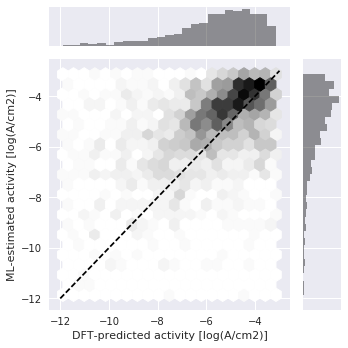

In [18]:
plot.filtered_parity(her_data, scale=scale, plot_type='hex', plot_range=[1e-12, 1e-3],
                     x_label='DFT-predicted activity [log(A/cm2)]',
                     y_label='ML-estimated activity [log(A/cm2)]',
                     title='Activity parity on surface minima')